In [1]:
import torch
from torchvision.transforms import Normalize, Resize, Compose, ToTensor
from PIL import Image
import torchvision.models as models
from collections import OrderedDict
import matplotlib.pyplot as plt
import skimage
import numpy as np

ModuleNotFoundError: No module named 'torch'

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
inception = models.inception_v3(pretrained=True)
#vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /home/joshmurr/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100.0%


In [4]:
class ModuleHook:
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
        self.module = None
        self.features = None

    def hook_fn(self, module, input, output):
        self.module = module
        self.features = output

    def close(self):
        self.hook.remove()

In [5]:
def hook_layers(net, prefix=[]):
    if hasattr(net, "_modules"):
        for name, layer in net._modules.items():
            if layer is None:
                continue
            features["_".join(prefix + [name])] = ModuleHook(layer)
            hook_layers(layer, prefix=prefix + [name])

In [6]:
features = OrderedDict()
hook_layers(inception)

for f in features:
      print(f)

Conv2d_1a_3x3
Conv2d_1a_3x3_conv
Conv2d_1a_3x3_bn
Conv2d_2a_3x3
Conv2d_2a_3x3_conv
Conv2d_2a_3x3_bn
Conv2d_2b_3x3
Conv2d_2b_3x3_conv
Conv2d_2b_3x3_bn
maxpool1
Conv2d_3b_1x1
Conv2d_3b_1x1_conv
Conv2d_3b_1x1_bn
Conv2d_4a_3x3
Conv2d_4a_3x3_conv
Conv2d_4a_3x3_bn
maxpool2
Mixed_5b
Mixed_5b_branch1x1
Mixed_5b_branch1x1_conv
Mixed_5b_branch1x1_bn
Mixed_5b_branch5x5_1
Mixed_5b_branch5x5_1_conv
Mixed_5b_branch5x5_1_bn
Mixed_5b_branch5x5_2
Mixed_5b_branch5x5_2_conv
Mixed_5b_branch5x5_2_bn
Mixed_5b_branch3x3dbl_1
Mixed_5b_branch3x3dbl_1_conv
Mixed_5b_branch3x3dbl_1_bn
Mixed_5b_branch3x3dbl_2
Mixed_5b_branch3x3dbl_2_conv
Mixed_5b_branch3x3dbl_2_bn
Mixed_5b_branch3x3dbl_3
Mixed_5b_branch3x3dbl_3_conv
Mixed_5b_branch3x3dbl_3_bn
Mixed_5b_branch_pool
Mixed_5b_branch_pool_conv
Mixed_5b_branch_pool_bn
Mixed_5c
Mixed_5c_branch1x1
Mixed_5c_branch1x1_conv
Mixed_5c_branch1x1_bn
Mixed_5c_branch5x5_1
Mixed_5c_branch5x5_1_conv
Mixed_5c_branch5x5_1_bn
Mixed_5c_branch5x5_2
Mixed_5c_branch5x5_2_conv
Mixed_5c_bran

In [49]:
normal = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def tensor_to_img_array(tensor):
    image = tensor.cpu().detach().numpy().squeeze()
    image = np.transpose(image, [1,2,0])
    return image

In [24]:
def get_astronaut_tensor(sidelength):
    img = Image.fromarray(skimage.data.astronaut())
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

In [78]:
shape = [1, 3, 224, 244]
image = torch.sigmoid((torch.rand(*shape) * 0.01).to(device)).requires_grad_(True)
#image = get_astronaut_tensor(224).unsqueeze(0).cuda().requires_grad_(True)
params = [image]
optimizer = torch.optim.Adam(params, lr=.01)
layer = 'Conv2d_2b_3x3_conv'
hooked_layer = features[layer]
n_channel = 12
n_steps = 2048

0.05%	- loss: 0.88
3.17%	- loss: 0.29
6.30%	- loss: 0.16
9.42%	- loss: 0.01
12.55%	- loss: -0.12
15.67%	- loss: -0.24
18.80%	- loss: -0.36
21.92%	- loss: -0.48
25.05%	- loss: -0.60
28.17%	- loss: -0.71
31.30%	- loss: -0.84
34.42%	- loss: -0.97
37.55%	- loss: -1.10
40.67%	- loss: -1.25
43.80%	- loss: -1.40
46.92%	- loss: -1.55
50.05%	- loss: -1.71
53.17%	- loss: -1.87
56.30%	- loss: -2.04
59.42%	- loss: -2.22
62.55%	- loss: -2.40
65.67%	- loss: -2.60
68.80%	- loss: -2.80
71.92%	- loss: -3.02
75.05%	- loss: -3.24
78.17%	- loss: -3.47
81.30%	- loss: -3.71
84.42%	- loss: -3.96
87.55%	- loss: -4.22
90.67%	- loss: -4.48
93.80%	- loss: -4.76
96.92%	- loss: -5.04


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


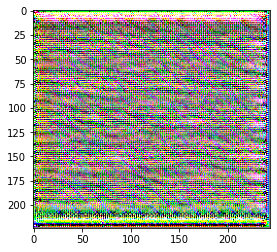

In [79]:
inception.to(device).eval()
for i in range(n_steps):
    optimizer.zero_grad()
    inception(normal(image)) # Forward pass
    loss = -hooked_layer.features[:, n_channel].mean()
    loss.backward()
    optimizer.step()
    
    if i % 64 == 1:
        print(f"{(i / n_steps * 100):.2f}%\t- loss: {loss.item():.2f}")

plt.imshow(tensor_to_img_array(image))